# Studying Biological Diversity

## Getting started: the sample by observation count/frequency table

From a bioinformatics perspective, studying biological diversity is centered around a few key pieces of information:

* A table of the counts (or relative abundances) of certain biological observations (e.g., species or OTUs) on a per sample basis.
* *Sample metadata* describing exactly what each of the samples is, as well as any relevant technical information. 
* Optionally, information on the relationships between the biological observations, typically in the form of a phylogenetic tree where tips in the tree correspond to OTUs in the table.

None of these are trival to generate (defining OTUs was described in the [OTU clustering chapter](../algorithms/5-sequence-mapping-and-clustering.ipynb), building trees in the [Phylogenetic reconstruction chapter](../algorithms/3-phylogeny-reconstruction.ipynb), and there is a lot of active work on standardized ways to describe samples in the form of metadata, for example [Yilmaz et al (2011)](http://www.nature.com/nbt/journal/v29/n5/full/nbt.1823.html) and the [isa-tab](http://isa-tools.org/) project. For this discussion we're going to largely ignore the complexities of generating each of these, so we can focus on how we study diversity.

<hr> 

The sample by observation count table is central to investigations of biological diversity. The Genomics Standards Consortium has recognized the [Biological Observation Matrix](http://www.biom-format.org) ([McDonald et al. (2011) *Gigascience*](http://www.gigasciencejournal.com/content/1/1/7)), or `biom-format` software and file format definition as a community standard for representing those tables. We'll use the `biom-format` python package here to work with these tables, and we'll refer to these tables through-out this chapter as *BIOM tables*.

The basic data that goes into a BIOM table is the list of sample ids, the list of observation (e.g., OTU) ids, and the count matrix, which describes how many times each OTU was observed in each sample. We can build and display a BIOM table as follows:

In [1]:
%pylab inline

from biom.table import table_factory, SparseOTUTable
from numpy import array

sample_ids = ['A', 'B', 'C']
observation_ids = ['OTU1', 'OTU2', 'OTU3', 'OTU4', 'OTU5']
data = array([[1, 0, 0],
              [3, 2, 0],
              [0, 0, 6],
              [1, 4, 2],
              [0, 4, 1]])

table1 = table_factory(data,
                  sample_ids,
                  observation_ids,
                  sample_md = [],
                  observation_md = [],
                  constructor=SparseOTUTable)

print table1

Populating the interactive namespace from numpy and matplotlib
# Constructed from biom file
#OTU ID	A	B	C
OTU1	1.0	0.0	0.0
OTU2	3.0	2.0	0.0
OTU3	0.0	0.0	6.0
OTU4	1.0	4.0	2.0
OTU5	0.0	4.0	1.0


The [biom-format API documentation](http://biom-format.org/documentation/table_objects.html) describes the functionality available for working with these tables once they're loaded. For example, if we want the observation count vector for sample `A` from the above table, we could get that as follows:

In [2]:
table1.sampleData('A')

array([ 1.,  3.,  0.,  1.,  0.])

**TODO**: Trees in newick format; sample metadata in tsv format, and loaded into a pandas DataFrame.

Before we start looking at what we can do with this data once we have it, let's discuss some terminology.

## Terminology

There are literally hundreds of metrics of biological diversity. Here is some terminology that is useful for classifying these metrics. 

**Alpha versus beta diversity**

 * $\alpha$ (i.e., within sample) diversity: Who is there? How many are there? 
 * $\beta$ (i.e., between sample) diversity: How similar are pairs of samples?    

**Quantitative versus qualitative metrics**

 * qualitative metrices only account for whether an organism is present or absent
 * quantitative metrics account for abundance 

**Phylogenetic versus non-phylogenetic metrics**

 * non-phylogenetic metrics treat all OTUs as being equally related
 * phylogenetic metrics incorporate evolutionary relationships between the OTUs


In the next sections we'll look at some metrics that cross these different categories. As new metrics are introduced, try to classify each them into one class for each of the above three categories.

## Measuring alpha diversity

The first type of metric that we'll look at will be alpha diversity, and we'll specifically focus on *richness* here. Richness refers to how many different *types* of organisms are present in a sample: for example, if we're interested in species richness of plants in the Sonoran Desert and the Costa Rican rainforest, we could go to each, count the number of different species of plants that we observe, and have a basic measure of species richness in each environment. 

An alternative type of alpha diversity measure would be *evenness*, and would tell us how even or uneven the distribution of species abundances are in a given environment. If, for example, the most abundant plant in the Sonoran desert was roughly as common as the least abundant plant (not the case!), we would say that the evenness of plant species was high. On the other hand, if the most abundant plant was thousands of times more common than the least common plant (probably closer to the truth), then we'd say that the evenness of plant species was low. We won't discuss evenness more here, but you can find coverage of this topic (as well as many of the others presented here) in [Measuring Biological Diversity](http://www.amazon.com/Measuring-Biological-Diversity-Anne-Magurran/dp/0632056339).

Let's look at two metrics of alpha diversity: observed species, and phylogenetic diversity.

#### Observed species (or Observed OTUs)

Observed species, or Observed OTUs as it's more accurately described, is about as simple of a metric as can be used to quantify alpha diversity. With this metric, we simply count the OTUs that are observed in a given sample. Note that this is a qualitative metric: we treat each OTU as being observed or not observed - we don't care how many times it was observed.

Let's define a new table for this analysis:

In [3]:
sample_ids = ['A', 'B', 'C']
observation_ids = ['B1','B2','B3','B4','B5','A1','E2']
data = array([[1, 1, 5],
              [1, 2, 0],
              [3, 1, 0],
              [0, 2, 0],
              [0, 0, 0],
              [0, 0, 3],
              [0, 0, 1]])

table2 = table_factory(data,
                  sample_ids,
                  observation_ids,
                  sample_md = [],
                  observation_md = [],
                  constructor=SparseOTUTable)

print table2

# Constructed from biom file
#OTU ID	A	B	C
B1	1.0	1.0	5.0
B2	1.0	2.0	0.0
B3	3.0	1.0	0.0
B4	0.0	2.0	0.0
B5	0.0	0.0	0.0
A1	0.0	0.0	3.0
E2	0.0	0.0	1.0


Our sample $A$ has an observed OTU count value of 3, sample $B$ has an observed OTU count of 4, and sample $C$ has an observed OTU count of 3. Note that this is different than the total counts for each column (which would be 5, 6, and 9 respectively). Based on the observed OTUs metric, we could consider samples $A$ and $C$ to have even OTU richness, and sample $B$ to have 33% higher OTU richness.

We could compute this in python as follows:

In [4]:
def observed_otus(table, sample_id):
    return sum([e > 0 for e in table.sampleData(sample_id)])

In [5]:
print observed_otus(table2, 'A')

3


In [6]:
print observed_otus(table2, 'B')

4


In [7]:
print observed_otus(table2, 'C')

3


#### A limitation of OTU counting

Imagine now that we have the same table, but some additional information about the OTUs in the table. Specifically, we've computed the following phylogenetic tree. And, for the sake of illustration, imagine that we've also assigned taxonomy to each of the OTUs and found that our samples contain representatives from the archaea, bacteria, and eukaryotes (their labels begin with `A`, `B`, and `E`, respectively).

<img src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/pd_calc_tree.png">

Pairing this with the table we defined above (displayed again in the cell below), given what you now now about these OTUs, which would you consider the most diverse? Are you happy with the $\alpha$ diversity conclusion that you obtained when computing the number of observed OTUs in each sample?

In [8]:
print table2

# Constructed from biom file
#OTU ID	A	B	C
B1	1.0	1.0	5.0
B2	1.0	2.0	0.0
B3	3.0	1.0	0.0
B4	0.0	2.0	0.0
B5	0.0	0.0	0.0
A1	0.0	0.0	3.0
E2	0.0	0.0	1.0


#### Phylogenetic Diversity (PD)

Phylogenetic Diversity (PD) is a metric that was developed by Dan Faith in the early 1990s (find the original paper [here](http://www.sciencedirect.com/science/article/pii/0006320792912013)). Like many of the measures that are used in microbial community ecology, it wasn't initially designed for studying microbial communities, but rather communities of "macro-organisms" (macrobes?). Some of these metrics, including PD, do translate well to microbial community analysis, while some don't translate as well. (For an illustration of the effect of sequencing error on PD, where it is handled well, versus it's effect on the Chao1 metric, where it is handled less well, see Figure 1 of [Reeder and Knight (2010)](http://www.nature.com/nmeth/journal/v7/n9/full/nmeth0910-668b.html)).

PD is relatively simple to calculate. It is computed simply as the sum of the branch length in a phylogenetic tree that is "covered" or represented in a given sample. Let's look at an example to see how this works.

First, let's define a phylogenetic tree using the newick format (which is described [here](http://evolution.genetics.washington.edu/phylip/newicktree.html), and more formally defined [here](http://evolution.genetics.washington.edu/phylip/newick_doc.html)). We'll then load that up with using [scikit-bio](http://scikit-bio.org)'s [TreeNode](http://scikit-bio.org/generated/skbio.core.tree.TreeNode.html#skbio.core.tree.TreeNode) object.

In [9]:
newick_tree = '(((B1:0.2,B2:0.3):0.3,((B3:0.5,B4:0.3):0.2,B5:0.9):0.3):0.35,(((A1:0.2,A2:0.3):0.3,(E1:0.3,E2:0.4):0.7):0.2):0.05)root;'

from skbio.tree import TreeNode

tree = TreeNode.from_newick(newick_tree)
tree = tree.root_at_midpoint()

I'll now define a couple of functions that we'll use to compute PD. 

In [10]:
def get_observed_nodes(tree, table, sample_id, verbose=False):
    observed_otus = [obs_id for obs_id in table.ObservationIds 
                if table.getValueByIds(obs_id, sample_id) > 0]
    observed_nodes = set()
    # iterate over the observed OTUs
    for otu in observed_otus:
        t = tree.find(otu)
        observed_nodes.add(t)
        if verbose:
            print t.name, t.length, 
        for internal_node in t.ancestors():
            if internal_node.length is None:
                # we've hit the root
                if verbose:
                    print
            else:
                if verbose and internal_node not in observed_nodes:
                    print internal_node.length,
                observed_nodes.add(internal_node)
    return observed_nodes

def phylogenetic_diversity(tree, table, sample_id, verbose=False):
    observed_nodes = get_observed_nodes(tree, table, sample_id, verbose=verbose)
    pd = sum(o.length for o in observed_nodes)
    return pd

And then apply those to compute the PD of our three samples. For each computation, we're also printing out the branch lengths of the branches that are observed *for the first time* when looking at a given OTU. When computing PD, we include the length of each branch only one time.

In [11]:
pd_A = phylogenetic_diversity(tree, table2, 'A', verbose=True)
print pd_A

B1 0.2 0.3 0.25
B2 0.3
B3 0.5 0.2 0.3
2.05


In [12]:
pd_B = phylogenetic_diversity(tree, table2, 'B', verbose=True)
print pd_B

B1 0.2 0.3 0.25
B2 0.3
B3 0.5 0.2 0.3
B4 0.3
2.35


In [13]:
pd_C = phylogenetic_diversity(tree, table2, 'C', verbose=True)
print pd_C

B1 0.2 0.3 0.25
A1 0.2 0.3 0.2 0.05 0.1
E2 0.4 0.7
2.7


How does this result compare to what we observed above with the Observed OTUs metric? Based on your knowledge of biology, which do you think is a better representation of the relative diversities of these samples?

#### Even sampling

Imagine again that we're going out to count plants in the Sonoran Desert and the Costa Rican rainforest. We're interested in getting an idea of the plant richness in each environment. In the Sonoran Desert, we survey a square kilometer area, and count 150 species of plants. In the rainforest, we survey a square meter, and count 15 species of plants. So, clearly the plant species richness in the Sonoran Desert is higher, right? What's wrong with this comparison?

The problem is that we've expended a lot more sampling effort in the desert than we did in the rainforest, so it shouldn't be surprising that we observed more species there. If we expended the same effort in the rainforest, we'd probably observe a lot more than 15 or 150 plant species, and we'd have a more sound comparison.

In sequencing-based studies of microorganism richness, the analog of sampling area is sequencing depth. If we collect 100 sequences from one sample, and 10,000 sequences from another sample, we can't directly compare the number of observed OTUs or the phylogenetic diversity of these because we expended a lot more sampling effort on the sample with 10,000 sequences than on the sample with 100 sequences. The way this is typically handled is by randomly subsampling sequences from the sample with more sequences until the sequencing depth is equal to that in the sample with fewer sequences. If we randomly select 100 sequences at random from the sample with 10,000 sequences, and compute the alpha diversity based on that random subsample, we'll have a better idea of the relative alpha diversities of the two samples.

In [14]:
sample_ids = ['A', 'B', 'C']
observation_ids = ['OTU1', 'OTU2', 'OTU3', 'OTU4', 'OTU5']
data = array([[50, 4, 0],
              [35, 200, 0],
              [100, 2, 1],
              [15, 400, 1],
              [0, 40, 1]])

bad_table = table_factory(data,
                  sample_ids,
                  observation_ids,
                  sample_md = [],
                  observation_md = [],
                  constructor=SparseOTUTable)

print bad_table

# Constructed from biom file
#OTU ID	A	B	C
OTU1	50.0	4.0	0.0
OTU2	35.0	200.0	0.0
OTU3	100.0	2.0	1.0
OTU4	15.0	400.0	1.0
OTU5	0.0	40.0	1.0


In [15]:
print observed_otus(bad_table, 'A')

4


In [16]:
print observed_otus(bad_table, 'B')

5


In [17]:
print observed_otus(bad_table, 'C')

3


In [18]:
print zip(bad_table.SampleIds, bad_table.sum('sample'))

[('A', 200.0), ('B', 646.0), ('C', 3.0)]


**TODO**: Add alpha rarefaction discussion.

## Measuring beta diversity

$\beta$-diversity (canonically pronounced *beta diversity*) refers to **between sample diversity**, and is typically used to answer questions of the form: is sample $A$ more similar in composition to sample $B$ or sample $C$? In this section we'll explore two (of tens or hundreds) of metrics for computing pairwise dissimilarity of samples to estimate $\beta$ diversity.

### Distance metrics

#### Bray-Curtis

The first metric that we'll look at is a quantitative non-phylogenetic $\beta$ diversity metric called Bray-Curtis. The Bray-Curtis dissimilarity between a pair of samples, $j$ and $k$, is defined as follows:

$BC_{jk} = \frac{ \sum_{i} | X_{ij} – X_{ik}|} {\sum_{i} (X_{ij} + X_{ik})}$

$i$ : observation (e.g., OTUs)

$X_{ij}$ : count of observation $i$ in sample $j$

$X_{ik}$ : count of observation $i$ in sample $k$

This could be implemented in python as follows:


In [19]:
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table.sampleData(sample1_id)
    sample2_counts = table.sampleData(sample2_id)
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

In [20]:
print table1

# Constructed from biom file
#OTU ID	A	B	C
OTU1	1.0	0.0	0.0
OTU2	3.0	2.0	0.0
OTU3	0.0	0.0	6.0
OTU4	1.0	4.0	2.0
OTU5	0.0	4.0	1.0


Let's now apply this to some pairs of samples:

In [21]:
print bray_curtis_distance(table1, 'A', 'B')

0.6


In [22]:
print bray_curtis_distance(table1, 'A', 'C')

0.857142857143


In [23]:
print bray_curtis_distance(table1, 'B', 'C')

0.684210526316


In [24]:
print bray_curtis_distance(table1, 'A', 'A')

0.0


In [25]:
print bray_curtis_distance(table1, 'C', 'B')

0.684210526316


Ultimately, we likely want to apply this to all pairs of samples to get a distance matrix containing all pairwise distances. Let's define a function for that, and then compute all pairwise Bray-Curtis distances between samples `A`, `B` and `C`.

In [26]:
from skbio.stats.distance import DistanceMatrix
from numpy import zeros

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.SampleIds
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = \
             pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

In [27]:
bc_dm = table_to_distances(table1, bray_curtis_distance)
print bc_dm

3x3 distance matrix
IDs:
'A', 'B', 'C'
Data:
[[ 0.          0.6         0.85714286]
 [ 0.6         0.          0.68421053]
 [ 0.85714286  0.68421053  0.        ]]


#### Unweighted UniFrac

Just as phylogenetic alpha diversity metrics can be more informative than non-phylogenetic alpha diversity metrics, phylogenetic beta diversity metrics offer advantages over non-phylogenetic metrics such as Bray-Curtis. The most widely applied phylogenetic beta diversity metric as of this writing is unweighted UniFrac. UniFrac was initially presented in [Lozupone and Knight, 2005, Applied and Environmental Microbiology](http://aem.asm.org/content/71/12/8228.abstract), and has been widely applied in microbial ecology since (and the illustration of UniFrac computation presented below is derived from a similar example originally developed by Lozupone and Knight).

The unweighted UniFrac distance between a pair of samples `A` and `B` is defined as follows:

$U_{AB} = \frac{unique}{observed}$

where:

$unique$ : the unique branch length, or branch length that only leads to OTU(s) observed in sample $A$ or sample $B$

$observed$ : the total branch length observed in either sample $A$ or sample $B$

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/unifrac_tree_d0.png" align=right/></div>

To illustrate how UniFrac distances are computed, before we get into actually computing them, let's look at a few examples. In these examples, imagine that we're determining the pairwise UniFrac distance between two samples: a red sample, and a blue sample. If a red box appears next to an OTU, that indicates that it's observed in the red sample; if a blue box appears next to the OTU, that indicates that it's observed in the blue sample; if a red and blue box appears next to the OTU, that indicates that the OTU is present in both samples; and if no box is presented next to the OTU, that indicates that it's present in neither sample.

To compute the UniFrac distance between a pair of samples, we need to know the sum of the branch length that was observed in either sample (the *observed* branch length), and the sum of the branch length that was observed only in a single sample (the *unique* branch length). In these examples, we color all of the *observed* branch length. Branch length that is unique to the red sample is red, branch length that is unique to the blue sample is blue, and branch length that is observed in both samples is purple. Unobserved branch length is black (as is the vertical branches, as those don't contribute to branch length - they are purely for visual presentation). 

In the tree on the right, all of the OTUs that are observed in either sample are observed in both samples. As a result, all of the observed branch length is purple. The unique branch length in this case is zero, so **we have a UniFrac distance of 0 between the red and blue samples**.

<hr>

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/unifrac_tree_d1.png" align=right/></div>

On the other end of the spectrum, in the second tree, all of the OTUs in the tree are observed either in the red sample, or in the blue sample. All of the observed branch length in the tree is either red or blue, meaning that if you follow a branch out to the tips, you will observed only red or blue samples. In this case the unique branch length is equal to the observed branch length, so **we have a UniFrac distance of 1 between the red and blue samples**.


<hr>

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/unifrac_tree_d0.5.png" align=right/></div>

Finally, most of the time we're somewhere in the middle. In this tree, some of our branch length is unique, and some is not. For example, OTU 1 is only observed in our red sample, so the terminal branch leading to OTU 1 is red (i.e., unique to the red sample). OTU 2 is only observed in our blue sample, so the terminal branch leading to OTU 2 is blue (i.e., unique to the blue sample). However, the internal branch leading to the node connecting OTU 1 and OTU 2 leads to OTUs observed in both the red and blue samples (i.e., OTU 1 and OTU 2), so is purple (i.e, observed branch length, but not unique branch length). In this case, **we have an intermediate UniFrac distance between the red and blue samples, maybe somewhere around 0.5**.

<hr>
<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/unifrac_tree_with_distances.png" align=right/></div>

Let's now compute the Unweighted UniFrac distances between some samples. Imagine we have the following tree, paired with our table below (printed below, for quick reference).

In [28]:
print table1

# Constructed from biom file
#OTU ID	A	B	C
OTU1	1.0	0.0	0.0
OTU2	3.0	2.0	0.0
OTU3	0.0	0.0	6.0
OTU4	1.0	4.0	2.0
OTU5	0.0	4.0	1.0


<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/unifrac_tree_with_distances_ab.png" align=right/></div>

First, let's compute the unweighted UniFrac distance between samples $A$ and $B$. The *unweighted* in *unweighted UniFrac* means that this is a qualitative diversity metric, meaning that we don't care about the abundances of the OTUs, only whether they are present in a given sample ($count > 0$) or not present ($count = 0$). 

Start at the top right branch in the tree, and for each branch, determine if the branch is observed, and if so, if it is also unique. If it is observed then you add its length to your observed branch length. If it is observed and unique, then you also add its length to your unique branch length. 

For samples $A$ and $B$, I get the following (in the tree on the right, red branches are those observed in $A$, blue branches are those observed in $B$, and purple are observed in both):

$unique_{ab} = 0.5 + 0.75 = 1.25$

$observed_{ab} = 0.5 + 0.5 + 0.5 + 1.0 + 1.25 + 0.75 + 0.75 = 5.25$

$uu_{ab} = \frac{unique_{ab}}{observed_{ab}} = \frac{1.25}{5.25} = 0.238$

As an exercise, now compute the UniFrac distances between samples $B$ and $C$, and samples $A$ and $C$, using the above table and tree. When I do this, I get the following distance matrix. 

In [29]:
ids = ['A', 'B', 'C']
d = [[0.00, 0.24, 0.52],
      [0.24, 0.00, 0.35],
      [0.52, 0.35, 0.00]]
print DistanceMatrix(d, ids)

3x3 distance matrix
IDs:
'A', 'B', 'C'
Data:
[[ 0.    0.24  0.52]
 [ 0.24  0.    0.35]
 [ 0.52  0.35  0.  ]]


 **TODO**: Interface change so this code can be used with ``table_to_distances``. 

In [30]:
## This is untested!! I'm not certain that it's exactly right, just a quick test.

newick_tree1 = '(((((OTU1:0.5,OTU2:0.5):0.5,OTU3:1.0):1.0),(OTU4:0.75,OTU5:0.75):1.25))root;'
tree1 = TreeNode.from_newick(newick_tree1)

def unweighted_unifrac(tree, table, sample_id1, sample_id2, verbose=False):
    observed_nodes1 = get_observed_nodes(tree, table, sample_id1, verbose=verbose)
    observed_nodes2 = get_observed_nodes(tree, table, sample_id2, verbose=verbose)
    observed_branch_length = sum(o.length for o in observed_nodes1 | observed_nodes2)
    shared_branch_length = sum(o.length for o in observed_nodes1 & observed_nodes2)
    unique_branch_length = observed_branch_length - shared_branch_length
    unweighted_unifrac = unique_branch_length / observed_branch_length
    return unweighted_unifrac

print unweighted_unifrac(tree1, table1, 'A', 'B')
print unweighted_unifrac(tree1, table1, 'A', 'C')
print unweighted_unifrac(tree1, table1, 'B', 'C')

0.238095238095
0.52
0.347826086957


#### Even sampling

**TODO**: Add discussion on necessity of even sampling

### Interpreting distance matrices

In the previous section we computed distance matrices that contained the pairwise distances between a few samples. You can look at those distance matrices and get a pretty good feeling for what the patterns are. For example, what are the most similar samples? What are the most dissimilar samples? 

What if instead of three samples though, we had more. Here's a screenshot from a distance martix containing data on 105 samples (this is just the first few rows and columns):

<img src='https://raw.githubusercontent.com/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/master/applications/images/example_big_dm.png', width=800>

Do you have a good feeling for the patterns here? What are the most similar samples? What are the most dissimilar samples? 

Chances are, you can't just squint at that table and understand what's going on (but if you can, I'm hiring!). The problem is exacerbated by the fact that in modern microbial ecology studies we may have thousands or tens of thousands of samples, not "just" hundreds as in the table above. We need tools to help us take these raw distances and convert them into something that we can interpret. In this section we'll look at some techniques, one of which we've covered previously, that will help us interpret large distance matrices.

<hr>

One excellent paper that includes a comparison of several different strategies for interpreting beta diversity results is [Costello *et al.* Science (2009) Bacterial Community Variation in Human Body Habitats Across Space and Time](https://www.sciencemag.org/content/326/5960/1694.full). In this study, the authors collected microbiome samples from 7 human subjects at about 25 sites on their bodies, at four different timepoints. 

Figure 1 shows several different approaches for comparing the resulting UniFrac distance matrix (this image is linked from the *Science* journal website - copyright belongs to *Science*):

<img src="https://www.sciencemag.org/content/326/5960/1694/F1.large.jpg" width=800>

Let's generate a small distance matrix representing just a few of these body sites, and figure out how we'd generate and interpret each of these visualizations. The values in the distance matrix below are a subset of the unweighted UniFrac distance matrix representing two samples each from three body sites from the Costello *et al.* (2009) study.

In [31]:
sample_ids = ['A', 'B', 'C', 'D', 'E', 'F']

human_microbiome_sample_md = {
                   'A': {'body_habitat': 'gut', 'person': 'subject 1'},
                   'B': {'body_habitat': 'gut', 'person': 'subject 2'},
                   'C': {'body_habitat': 'tongue', 'person': 'subject 1'},
                   'D': {'body_habitat': 'tongue', 'person': 'subject 2'},
                   'E': {'body_habitat': 'skin', 'person': 'subject 1'},
                   'F': {'body_habitat': 'skin', 'person': 'subject 2'}}

dm_data = array([[0.00, 0.35, 0.83, 0.83, 0.90, 0.90],
                 [0.35, 0.00, 0.86, 0.85, 0.92, 0.91],
                 [0.83, 0.86, 0.00, 0.25, 0.88, 0.87],
                 [0.83, 0.85, 0.25, 0.00, 0.88, 0.88],
                 [0.90, 0.92, 0.88, 0.88, 0.00, 0.50],
                 [0.90, 0.91, 0.87, 0.88, 0.50, 0.00]])

human_microbiome_dm = DistanceMatrix(dm_data, sample_ids)
print human_microbiome_dm

6x6 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E', 'F'
Data:
[[ 0.    0.35  0.83  0.83  0.9   0.9 ]
 [ 0.35  0.    0.86  0.85  0.92  0.91]
 [ 0.83  0.86  0.    0.25  0.88  0.87]
 [ 0.83  0.85  0.25  0.    0.88  0.88]
 [ 0.9   0.92  0.88  0.88  0.    0.5 ]
 [ 0.9   0.91  0.87  0.88  0.5   0.  ]]


#### Distribution plots and comparisons

First, let's look at the analysis presented in panels E and F. Instead of generating bar plots here, we'll generate box plots as these are more informative (i.e., they provide a more detailed summary of the distribution being investigated). One important thing to notice here is the central role that the sample metadata plays in the visualization. If we just had our sample ids (i.e., letters ``A`` through ``F``) we wouldn't be able to group distances into *within* and *between* sample type categories, and we therefore couldn't perform the comparisons we're interested in.

In [32]:
def within_between_category_distributions(dm, md, md_category):
    within_category_distances = []
    between_category_distances = []
    for i, sample_id1 in enumerate(dm.ids):
        sample_md1 = md[sample_id1][md_category]
        for sample_id2 in dm.ids[:i]:
            sample_md2 = md[sample_id2][md_category]
            if sample_md1 == sample_md2:
                within_category_distances.append(dm[sample_id1, sample_id2])
            else:
                between_category_distances.append(dm[sample_id1, sample_id2])
    return within_category_distances, between_category_distances

In [33]:
within_category_distances, between_category_distances = \
    within_between_category_distributions(human_microbiome_dm, human_microbiome_sample_md, "body_habitat")
print within_category_distances
print between_category_distances

[0.34999999999999998, 0.25, 0.5]
[0.82999999999999996, 0.85999999999999999, 0.82999999999999996, 0.84999999999999998, 0.90000000000000002, 0.92000000000000004, 0.88, 0.88, 0.90000000000000002, 0.91000000000000003, 0.87, 0.88]


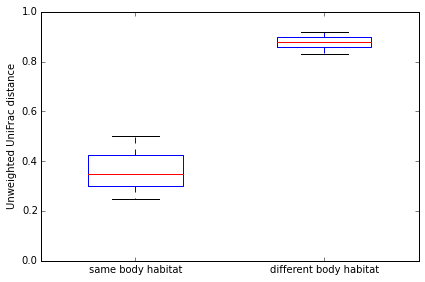

In [34]:
from skbio.draw import boxplots

plot = boxplots([within_category_distances, between_category_distances],
                x_tick_labels=['same body habitat', 'different body habitat'],
                x_tick_labels_orientation='horizontal',
                y_label="Unweighted UniFrac distance",
                y_min=0.0, y_max=1.0)

In [35]:
from scipy.stats import ttest_ind
t, p_value = ttest_ind(within_category_distances, between_category_distances)
print t, p_value

-14.0187203101 3.17133166547e-09


If we run through these same steps, but base our analysis on a different metadata category where we don't expect to see any significant clustering, you can see that we no longer get a significant result.

In [36]:
within_category_distances, between_category_distances = \
    within_between_category_distributions(human_microbiome_dm, human_microbiome_sample_md, "person")
print within_category_distances
print between_category_distances

[0.82999999999999996, 0.84999999999999998, 0.90000000000000002, 0.88, 0.91000000000000003, 0.88]
[0.34999999999999998, 0.85999999999999999, 0.82999999999999996, 0.25, 0.92000000000000004, 0.88, 0.90000000000000002, 0.87, 0.5]


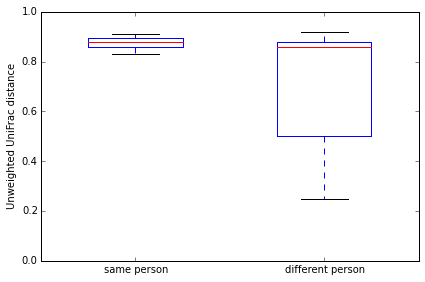

In [37]:
plot = boxplots([within_category_distances, between_category_distances],
                x_tick_labels=['same person', 'different person'],
                x_tick_labels_orientation='horizontal',
                y_label="Unweighted UniFrac distance",
                y_min=0.0, y_max=1.0)

In [38]:
t, p_value = ttest_ind(within_category_distances, between_category_distances)
print t, p_value

1.53700820694 0.148267378899


Why do you think the distribution of distances between people has such as larger range than the distribution of distances within people in this particular example?

#### Heirarchical clustering

Next, let's look at a hierarchical clustering analysis, similar to that presented in panel G above. Here I'm applying the UPGMA functionality implemented in [scipy](http://www.scipy.org/scipylib/index.html) to generate a tree which we visualize with a dendrogram. However the tips in this tree don't represent sequences or OTUs, like they did when we covered UPGMA in the [Phylogenetic reconstruction chapter](../algorithms/3-phylogeny-reconstruction.ipynb) chapter, but instead they represent samples, and samples with a smaller branch length between them are more similar in composition than samples with a longer branch length between them. (Remember that only horizontal branch length is counted - vertical branch length is just to aid in the organization of the dendrogram.)

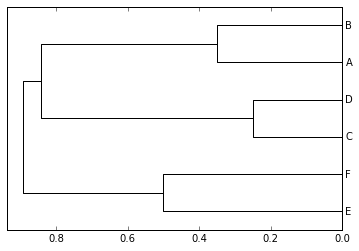

In [39]:
from scipy.cluster.hierarchy import average, dendrogram
lm = average(human_microbiome_dm.condensed_form())
d = dendrogram(lm, labels=human_microbiome_dm.ids, orientation='right', 
               link_color_func=lambda x: 'black')

Again, we can see how the data really only becomes interpretable in the context of metadata:

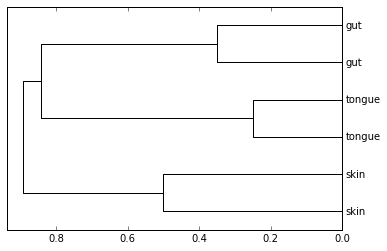

In [40]:
labels = [human_microbiome_sample_md[sid]['body_habitat'] for sid in sample_ids]
d = dendrogram(lm, labels=labels, orientation='right', 
               link_color_func=lambda x: 'black')

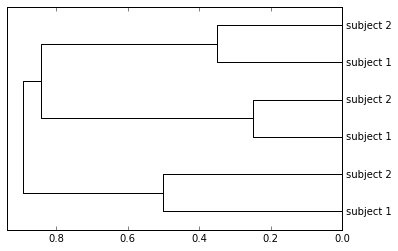

In [41]:
labels = [human_microbiome_sample_md[sid]['person'] for sid in sample_ids]
d = dendrogram(lm, labels=labels, orientation='right', 
               link_color_func=lambda x: 'black')

### Ordination

Finally, let's look at ordination, similar to that presented in panels A-D. The basic idea behind oridination is dimensionality reduction: we want to take high-dimensionality data (a distance matrix) and represent that in a few (usually two or three) dimensions. As humans, we're very bad at interpreting high dimensionality data directly: with ordination, we can take an $n$-dimensional data set (e.g., a distance matrix of shape $n \times n$, representing the distances between $n$ biological samples) and reduce that to a 2-dimensional scatter plot similar to that presented in panels A-D above. 

Ordination is a technique that is widely applied in ecology and in bioinformatics, but the math behind some of the methods such as *Principal Coordinates Analysis* is fairly complex, and as a result I've found that these methods are a black box for a lot of people. Possibly the most simple ordination technique is one called Polar Ordination. Polar Ordination is not widely applied because it has some incovenient features, but I find that it is useful for introducing the idea behind ordination. Here we'll work through a simple implementation of ordination to illustrate the process, which will help us to interpret ordination plots. In practice, you will use existing software, such as [scikit-bio](http://scikit-bio.org)'s [ordination module](http://scikit-bio.org/maths.stats.ordination.html). 

An excellent site for learning more about ordination is [Michael W. Palmer's Ordination Methods page](http://ordination.okstate.edu/).


#### Polar ordination

First, let's print our distance matrix again so we have it nearby.

In [42]:
print human_microbiome_dm

6x6 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E', 'F'
Data:
[[ 0.    0.35  0.83  0.83  0.9   0.9 ]
 [ 0.35  0.    0.86  0.85  0.92  0.91]
 [ 0.83  0.86  0.    0.25  0.88  0.87]
 [ 0.83  0.85  0.25  0.    0.88  0.88]
 [ 0.9   0.92  0.88  0.88  0.    0.5 ]
 [ 0.9   0.91  0.87  0.88  0.5   0.  ]]


Polar ordination works in a few steps:

**Step 1.** Identify the largest distance in the distance matrix.

**Step 2.** Define a line, with the two samples contributing to that distance defining the endpoints.

**Step 3.** Compute the location of each other sample on that axis as follows:

$a = \frac{D^2 + D1^2 - D2^2}{2 \times D}$
   
where:

$D$ is distance between the endpoints

$D1$ is distance between the current sample and endpoint 1

$D2$ is distance between sample and endpoint 2.

**Step 4.** Find the next largest distance that could be used to define an *uncorrelated axis*. (This step can be labor-intensive to do by hand – usually you would compute all of the axes, along with correlation scores. I’ll pick one for the demo, and we'll wrap up by looking at all of the axes.)

Here is what steps 2 and 3 look like in python:

In [43]:
def compute_axis_values(dm, endpoint1, endpoint2):
    d = dm[endpoint1, endpoint2]
    result = {endpoint1: 0, endpoint2: d}
    non_endpoints = set(dm.ids) - set([endpoint1, endpoint2])
    for e in non_endpoints:
        d1 = dm[endpoint1, e]
        d2 = dm[endpoint2, e]
        result[e] = (d**2 + d1**2 - d2**2) / (2 * d)
    return d, [result[e] for e in dm.ids]

In [44]:
d, a1_values = compute_axis_values(human_microbiome_dm, 'B', 'E')
for sid, a1_value in zip(human_microbiome_dm.ids, a1_values):
    print sid, a1_value

A 0.0863586956522
B 0
C 0.441086956522
D 0.431793478261
E 0.92
F 0.774184782609


In [45]:
d, a2_values = compute_axis_values(human_microbiome_dm, 'D', 'E')
for sid, a2_value in zip(human_microbiome_dm.ids, a2_values):
    print sid, a2_value

A 0.371193181818
B 0.369602272727
C 0.0355113636364
D 0
E 0.88
F 0.737954545455


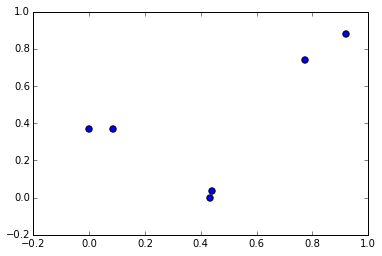

In [46]:
from pylab import scatter
ord_plot = scatter(a1_values, a2_values, s=40)

And again, let's look at how including metadata helps us to interpret our results.

First, we'll color the points by the body habitat that they're derived from:

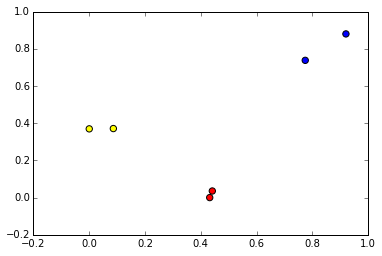

In [47]:
colors = {'tongue': 'red', 'gut':'yellow', 'skin':'blue'}
c = [colors[human_microbiome_sample_md[e]['body_habitat']] for e in human_microbiome_dm.ids]
ord_plot = scatter(a1_values, a2_values, s=40, c=c)

And next we'll color the samples by the person that they're derived from. Notice that this plot and the one above are identical except for coloring. Think about how the colors (and therefore the sample metadata) help you to interpret these plots.

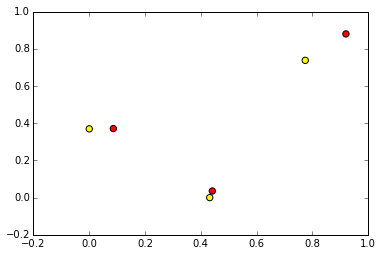

In [48]:
person_colors = {'subject 1': 'red', 'subject 2':'yellow'}
person_c = [person_colors[human_microbiome_sample_md[e]['person']] for e in human_microbiome_dm.ids]
ord_plot = scatter(a1_values, a2_values, s=40, c=person_c)

#### Determining the most important axes in polar ordination

Generally, you would compute the polar ordination axes for all possible axes. You could then order the axes by which represent the largest differences in sample composition, and the lowest correlation with previous axes. This might look like the following:

In [49]:
from scipy.stats import spearmanr

data = []
for i, sample_id1 in enumerate(human_microbiome_dm.ids):
    for sample_id2 in human_microbiome_dm.ids[:i]:
        d, axis_values = compute_axis_values(human_microbiome_dm, sample_id1, sample_id2)
        r, p = spearmanr(a1_values, axis_values)
        data.append((d, abs(r), sample_id1, sample_id2, axis_values))

data.sort()
data.reverse()
for i, e in enumerate(data):
    print "axis %d:" % i, 
    print "\t%1.3f\t%1.3f\t%s\t%s" % e[:4]

axis 0: 	0.920	1.000	E	B
axis 1: 	0.910	0.943	F	B
axis 2: 	0.900	0.928	E	A
axis 3: 	0.900	0.886	F	A
axis 4: 	0.880	0.543	E	D
axis 5: 	0.880	0.429	F	D
axis 6: 	0.880	0.429	E	C
axis 7: 	0.870	0.371	F	C
axis 8: 	0.860	0.543	C	B
axis 9: 	0.850	0.486	D	B
axis 10: 	0.830	0.429	C	A
axis 11: 	0.830	0.406	D	A
axis 12: 	0.500	0.232	F	E
axis 13: 	0.350	0.143	B	A
axis 14: 	0.250	0.493	D	C


So why do we care about axes being uncorrelated? And why do we care about explaining a lot of the variation? Let's look at a few of these plots and see how they compare to the plots above, where we compared axes 1 and 4.

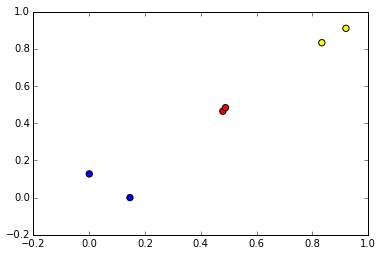

In [50]:
ord_plot = scatter(data[0][4], data[1][4], s=40, c=c)

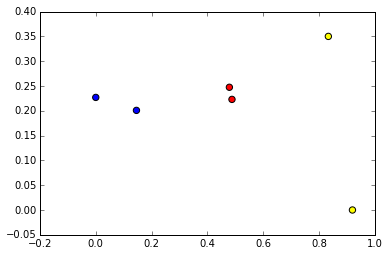

In [51]:
ord_plot = scatter(data[0][4], data[13][4], s=40, c=c)

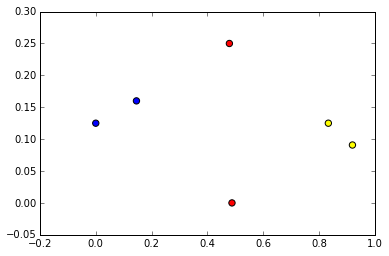

In [52]:
ord_plot = scatter(data[0][4], data[14][4], s=40, c=c)

#### Interpreting ordination plots

There are a few points that are important to keep in mind when interpreting ordination plots. Review each one of these in the context of polar ordination to figure out the reason for each.

**Directionality of the axes is not important (e.g., up/down/left/right)**

One thing that you may have notices as you computed the polar ordination above is that the method is *not symmetric*: in other words, the axis values for axis $EB$ are different than for axis $BE$. In practice though, we derive the same conclusions regardless of how we compute that axis: in this example, that samples cluster by body site.

In [53]:
d, a1_values = compute_axis_values(human_microbiome_dm, 'E', 'B')
d, a2_values = compute_axis_values(human_microbiome_dm, 'E', 'D')
d, alt_a1_values = compute_axis_values(human_microbiome_dm, 'B', 'E')

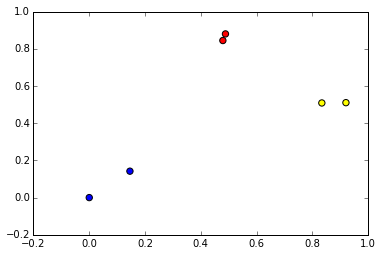

In [54]:
ord_plot = scatter(a1_values, a2_values, s=40, c=c)

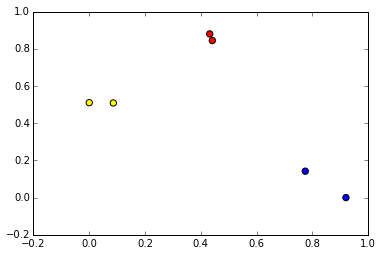

In [55]:
ord_plot = scatter(alt_a1_values, a2_values, s=40, c=c)

Some other important features:

* Numerical scale of the axis is generally not useful
* The order of axes is generally important (first axis explains the most variation, second axis explains the second most variation, ...)
* Most techniques result in uncorrelated axes.
* Additional axes can be generated (third, fourth, ...)

## Tools for using ordination in practice: scikit-bio, pandas, and matplotlib

As I mentioned above, polar ordination isn't widely used in practice, but the features that it illustrates are common to ordination methods. One of the most widely used ordination methods used to study biological diversity is Principal Coordinates Analysis or PCoA, which is implemented in [scikit-bio](http://scikit-bio.org/)'s [``ordination`` module](http://scikit-bio.org/maths.stats.ordination.html) (among many other packages). 

In this setion, we're going to make use of three python third-party modules to apply PCoA and visualize the results 3D scatter plots. The data we'll use here is the full unweighted UniFrac distance matrix from a study of soil microbial communities across North and South America (originally published in [Lauber *et al.* (2009)](http://www.ncbi.nlm.nih.gov/pubmed/19502440)). We're going to use [pandas](http://pandas.pydata.org/) to manage the metadata, [scikit-bio](http://scikit-bio.org/) to manage the distance matrix and compute PCoA, and [matplotlib](http://matplotlib.org/) to visualize the results.

First, we'll load sample metadata into a [pandas DateFrame](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.html). These are really useful for loading and working with the type of tabular information that you'd typically store in a spreadsheet or database table. (Note that one thing I'm doing in the following cell is tricking pandas into thinking that it's getting a file as input, even though I have the information represented as tab-separated lines in a multiline string. [python's StringIO](https://docs.python.org/2/library/stringio.html) is very useful for this, and it's especially convenient in your unit tests... which you're writing for all of your code, right?) Here we'll load the tab-separated text, and then print it.


In [56]:
from iab.data import lauber_soil_sample_md

lauber_soil_sample_md

,pH,ENVO biome,Latitude
CF3.141691,3.56,ENVO:Temperate broadleaf and mixed forest biome,42.116667
PE5.141692,3.57,ENVO:Tropical humid forests,-12.633333
BF2.141708,3.61,ENVO:Temperate broadleaf and mixed forest biome,41.583333
CF2.141679,3.63,ENVO:Temperate broadleaf and mixed forest biome,41.933333
CF1.141675,3.92,ENVO:Temperate broadleaf and mixed forest biome,42.158333
HF2.141686,3.98,ENVO:Temperate broadleaf and mixed forest biome,42.500000
BF1.141647,4.05,ENVO:Temperate broadleaf and mixed forest biome,41.583333
PE4.141683,4.10,ENVO:Tropical humid forests,-13.083333
PE2.141725,4.11,ENVO:Tropical humid forests,-13.083333
PE1.141715,4.12,ENVO:Tropical humid forests,-13.083333


Just as one simple example of the many things that pandas can do, to look up a value, such as the pH of sample ``MT2.141698``, we can do the following. If you're interesting in learning more about pandas, [*Python for Data Analysis*](http://shop.oreilly.com/product/0636920023784.do) is a very good resource.

In [57]:
lauber_soil_sample_md['pH']['MT2.141698']

6.6600000000000001

Next we'll load our distance matrix. This is similar to ``human_microbiome_dm_data`` one that we loaded above, just a little bigger. After loading, we can visualize the resulting ``DistanceMatrix`` object for a summary.

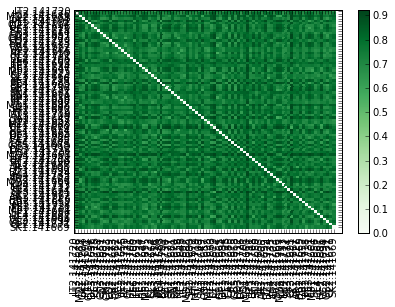

In [58]:
from iab.data import lauber_soil_unweighted_unifrac_dm

_ = lauber_soil_unweighted_unifrac_dm.plot(cmap='Greens')

Does this visualization help you to interpret the results? Probably not. Generally we'll need to apply some approaches that will help us with interpretation. Let's use ordination here. We'll run Pricipal Coordinates Analysis on our ``DistanceMatrix`` object. This gives us a matrix of coordinate values for each sample, which we can then plot. We can use ``scikit-bio``'s implementation of PCoA as follows:

In [60]:
from skbio.stats.ordination import PCoA

# Create the PCoA object...
lauber_soil_unweighted_unifrac_pcoa = PCoA(lauber_soil_unweighted_unifrac_dm)
# ... and run PCoA
lauber_soil_unweighted_unifrac_result = lauber_soil_unweighted_unifrac_pcoa.scores()


What does the following ordination plot tell you about the relationship between the similarity of microbial communities taken from similar and dissimilar latitudes?

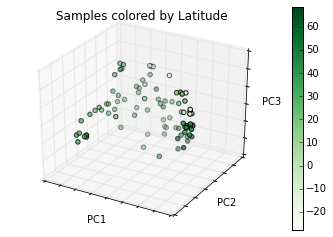

In [61]:
_ = lauber_soil_unweighted_unifrac_result.plot(lauber_soil_sample_md, 'Latitude', cmap='Greens', title="Samples colored by Latitude", axis_labels=('PC1', 'PC2', 'PC3'))

If the answer to the above question is that there doesn't seem to be much association, you're on the right track. We can qualtify this, for example, by testing for correlation between pH and value on PC 1.

In [62]:
from scipy.stats import spearmanr
spearman_rho, spearman_p = spearmanr(lauber_soil_unweighted_unifrac_result.site.T[0], 
                                     [lauber_soil_sample_md['Latitude'][sample_id] for sample_id in lauber_soil_unweighted_unifrac_result.site_ids])
print('rho: %1.3f' % spearman_rho)
print('p-value: %1.1e' % spearman_p)

rho: 0.158
p-value: 1.4e-01


In the next plot, we'll color the points by the pH of the soil sample they represent. What does this plot suggest about the relationship between the similarity of microbial communities taken from similar and dissimilar pH? 

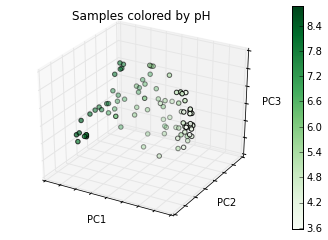

In [63]:
_ = lauber_soil_unweighted_unifrac_result.plot(lauber_soil_sample_md, 'pH', cmap='Greens', title="Samples colored by pH", axis_labels=('PC1', 'PC2', 'PC3'))

In [64]:
spearman_rho, spearman_p = spearmanr(lauber_soil_unweighted_unifrac_result.site.T[0], 
                                     [lauber_soil_sample_md['pH'][sample_id] for sample_id in lauber_soil_unweighted_unifrac_result.site_ids])
print('rho: %1.3f' % spearman_rho)
print('p-value: %1.1e' % spearman_p)

rho: -0.958
p-value: 1.9e-48


Taken together, these plots and statistics suggest that soil microbial community composition is much more closely associated with pH than it is with latitude: the key result that was presented in [Lauber *et al.* (2009)](http://www.ncbi.nlm.nih.gov/pubmed/19502440). 

## PCoA versus PCA: what's the difference?


You may have also heard of a method related to PCoA, called Principal Components Analysis or PCA. There is a key difference between these methods that is important for our useds. PCoA, which is what we've been working with, performs ordination with a distance matrix as input. PCA on the other hand performs ordination with sample by observation count data, such as the OTU tables that we've been working with, as input. It achieves this by computing Euclidean distance (see [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html#scipy.spatial.distance.euclidean)) between the samples and then running PCoA. So, if your distance metric is Euclidean, PCA and PCoA are the same. In practice however, we want to be able to use distance metrics that work better for studying biological diversity, such as Bray-Curtis or UniFrac. Therefore we typically compute distances with whatever metric we want, and then run PCoA. 


## Are two different analysis approaches giving me the same result?

A question that comes up frequently, often in method comparison, is whether two different approaches for analyzing some data giving the consistent results. This could come up, for example, if you were comparing DNA sequence data from the same samples generated on the 454 Titanium platform with data generated on the Illumina MiSeq platform to see if you would derive the same biological conclusions based on either platform. This was done, for example, in [Additional Figure 1](http://genomebiology.com/2011/12/5/R50/additional) of [*Moving Pictures of the Human Microbiome*](http://genomebiology.com/content/12/5/R50). Similarly, you might wonder if two different OTU clustering methods or beta diversity metrics would lead you to the same biological conclusion. Let's look at one way that you might address this question.

Imagine you ran three different beta diversity metrics on your BIOM table: unweighted UniFrac, Bray-Curtis, and weighted UniFrac (the quantitative analog of unweighted UniFrac), and then generated the following PCoA plots.

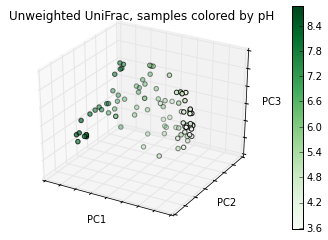

In [65]:
_ = lauber_soil_unweighted_unifrac_result.plot(lauber_soil_sample_md, 'pH', cmap='Greens', 
                                               title="Unweighted UniFrac, samples colored by pH",
                                               axis_labels=('PC1', 'PC2', 'PC3'))

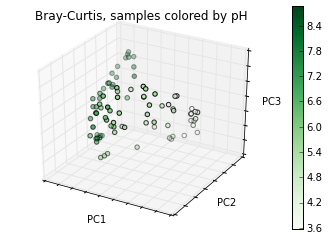

In [66]:
from iab.data import lauber_soil_bray_curtis_dm

lauber_soil_bray_curtis_pcoa = PCoA(lauber_soil_bray_curtis_dm)
lauber_soil_bray_curtis_result = lauber_soil_bray_curtis_pcoa.scores()

_ = lauber_soil_bray_curtis_result.plot(lauber_soil_sample_md, 'pH', cmap='Greens', 
                                        title="Bray-Curtis, samples colored by pH",
                                        axis_labels=('PC1', 'PC2', 'PC3'))

/Users/caporaso/.virtualenvs/iab/lib/python2.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:107: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0102916697563 and the largest is 3.83742007441.
  RuntimeWarning


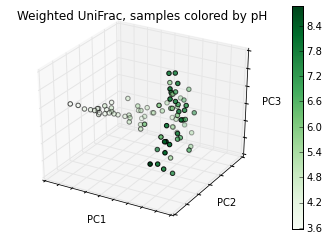

In [67]:
from iab.data import lauber_soil_weighted_unifrac_dm

lauber_soil_weighted_unifrac_pcoa = PCoA(lauber_soil_weighted_unifrac_dm)
lauber_soil_weighted_unifrac_result = lauber_soil_weighted_unifrac_pcoa.scores()

_ = lauber_soil_weighted_unifrac_result.plot(lauber_soil_sample_md, 'pH', cmap='Greens', 
                                             title="Weighted UniFrac, samples colored by pH",
                                             axis_labels=('PC1', 'PC2', 'PC3'))

Specifically, what we want to ask when comparing these results is **given a pair of ordination plots, is their shape (in two or three dimensions) the same?** The reason we care is that we want to know, **given a pair of ordination plots, would we derive the same biological conclusions regardless of which plot we look at?**

We can use a [Mantel test](http://scikit-bio.org/docs/latest/generated/generated/skbio.stats.distance.mantel.html) for this, which is way of testing for correlation between distance matrics. 

In [68]:
from skbio.stats.distance import mantel

r, p, n = mantel(lauber_soil_unweighted_unifrac_dm, lauber_soil_weighted_unifrac_dm, method='spearman', strict=False)
print("Mantel r: %1.3f" % r)
print("p-value: %1.1e" % p)
print("Number of samples compared: %d" % n)

Mantel r: 0.906
p-value: 1.0e-03
Number of samples compared: 88


In [69]:
r, p, n = mantel(lauber_soil_unweighted_unifrac_dm, lauber_soil_bray_curtis_dm, method='spearman', strict=False)
print("Mantel r: %1.3f" % r)
print("p-value: %1.1e" % p)
print("Number of samples compared: %d" % n)

Mantel r: 0.930
p-value: 1.0e-03
Number of samples compared: 88


In [70]:
r, p, n = mantel(lauber_soil_weighted_unifrac_dm, lauber_soil_bray_curtis_dm, method='spearman', strict=False)
print("Mantel r: %1.3f" % r)
print("p-value: %1.1e" % p)
print("Number of samples compared: %d" % n)

Mantel r: 0.850
p-value: 1.0e-03
Number of samples compared: 88


The way that we'd interpret these results is that, although the plots above look somewhat different from one another, the underlying data (the distances between samples) are highly correlated across the different diversity metrics. As a result, we'd conclude that with any of these three diversity metrics we'd come to the conclusion that samples that are more similar in pH are more similar in their microbial community composition.

We could apply this same approach, for example, if we had clustered sequences into OTUs with two different approaches. For example, if we used *de novo* OTU picking and open reference OTU picking, we could compute UniFrac distance matrices based on each resulting BIOM table, and then compare those distance matrices with a Mantel test. This approach was applied in [Rideout et al 2014](https://peerj.com/articles/545/) to determine which OTU clustering methods would result in different biological conclusions being drawn from a data set.

### Procrustes analysis

A related approach, but which I think is less useful as it compares PCoA plots directly (and therefore a summary of the distance data, rather than the distance data itself) is called Procrustes analysis (you can read about the origin of the name [here](http://en.wikipedia.org/wiki/Procrustes)). Procrustes analysis takes two coordinate matrices as input and effectively tries to find the best superimposition of one on top of the other. The transformations that are applies are as follows:

* Translation (the mean of all points is set to 1 on each dimension)
* Scaling (root mean square distance of all points from the origin is 1 on each dimension)
* Rotation (choosing one set of points as the reference, and rotate the other to minimize the sum of squares distance (SSD) between the corresponding points)

The output is a pair of *transformed coordinate matrices*, and an $M^{2}$ statistic which represents how dissimilar the coordinate matrices are to each other (so a small $M^{2}$ means that the coordinate matrices, and the plots, are more similar). [Procrustes analysis is implemented in scikit-bio](http://scikit-bio.org/generated/skbio.maths.stats.spatial.procrustes.html).


## Where to go from here

If you're interested in learning more about the topics presented in this chapter, I recommend [Measuring Biological Diversity](http://www.amazon.com/Measuring-Biological-Diversity-Anne-Magurran/dp/0632056339) by Anne E. Magurran, and the [QIIME tutorials](http://qiime.org/tutorials/index.html). The [QIIME software package](http://www.qiime.org) is designed for performing the types of analyses described in this chapter. 

## Acknowledgements

The majority of content in this section is based on knowledge that I gained through years of working with [Rob Knight](https://knightlab.colorado.edu/) and the rest of the [QIIME](http://qiime.org/) [development group](https://github.com/biocore/qiime/graphs/contributors). Thanks everyone, I'm looking forward to many more years of productive, fun and exciting work together!